In [1]:
import os

import numpy as np
import uproot
import matplotlib.pyplot as plt
import modplot
from glob import glob

In [2]:
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

In [3]:
def find_string_vals_in_file(file_name, string_to_search):
    """ Return values from all lines in the file that contains given string """
    vals = []
    # Open the file in read only mode
    with open(file_name, 'r') as read_obj:
        # Read all lines in the file one by one
        for line in read_obj:
            # For each line, check if line contains the string
            if string_to_search in line:
                vals.append(line)
                #vals.append(line.split(': ')[-1].split('\n')[0])
                #return True
    if len(vals) == 1:
        return vals[0]
    return vals

## Loading the Data

In [4]:
# pass in the full directory
data_path = '/Users/anthonybadea/Documents/ATLAS/data/simResults_051920_102540' 
list_of_dirs = glob(data_path+'/*')
# construct a list of dictionaries for each data file
data = []
for direct in list_of_dirs:
    file = glob(direct+'/stdout*.txt')[0]
    # load the parameters
    nEvent = float(find_string_vals_in_file(file,'muons triggered out of ').split('out of ')[-1].split(' muons that should trigger\n')[0])
    bkgRate = float(find_string_vals_in_file(file,' >> Background rate of ').split('>> Background rate of ')[-1].split(' Hz per strip')[0])
    mmEffs = [float(i.split(':')[-1].split('\n')[0]) for i in find_string_vals_in_file(file,"MM efficiency")]
    # load the data
    data_file = glob(direct+'/*.root')[0]
    data_file = uproot.open(data_file)
    real_x_muon = data_file['gingko']['real_x_muon'].array()
    real_y_muon = data_file['gingko']['real_y_muon'].array()
    trig_x = data_file['gingko']['trig_x'].array()
    trig_y = data_file['gingko']['trig_y'].array()
    # append dictionary of parameters and data
    data.append({'nEvent':nEvent,
                 'bkgRate':bkgRate,
                 'mmEffs':mmEffs,
                 'real_x_muon':real_x_muon,
                 'real_y_muon':real_y_muon,
                 'trig_x':trig_x,
                 'trig_y':trig_y,})

## Plot a sample distribution

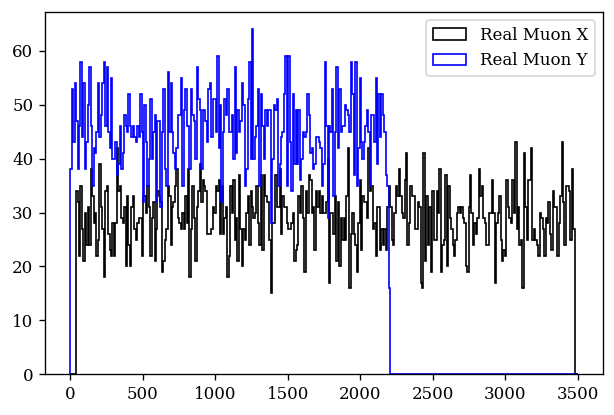

In [6]:
'''
# compute the distributions to determine the bin-by-bin corrections
bins = np.linspace(0, 3500, 350)
density = False
#plt.hist(nature['data_thrusts'], bins=bins, histtype='step', color='black', density=density)
real_x_muon_hist = plt.hist(data[0]['real_x_muon'], bins=bins, histtype='step', color='black', density=density, label='Real Muon X')[0]
real_y_muon_hist = plt.hist(data[0]['real_y_muon'], bins=bins, histtype='step', color='blue', density=density, label='Real Muon Y')[0]
#trig_x_hist = plt.hist(trig_x, bins=bins, histtype='step', color='red', density=density)[0]
#trig_y_hist = plt.hist(trig_y, bins=bins, histtype='step', color='green', density=density)[0]

#plt.yscale('log')
plt.legend(loc="upper right")
plt.show()
'''

## Compute the distributions of interest

In [17]:
# Calculate the number of triggered muons 
# This computation takes a while
xCut = 5
yCut = 5
counter = 0
print('----------------------------------------')
print('Computing the number of triggered muons')
for job in data:
    if counter % 10 == 0: print("Job {}/{}".format(counter,len(data)))
    real_x_muon = job['real_x_muon']
    real_y_muon = job['real_y_muon']
    trig_x = job['trig_x']
    trig_y = job['trig_y']
    TObs = 0
    for i in range(len(real_x_muon)):
        realMuonX = real_x_muon[i]
        realMuonY = real_y_muon[i]
        for j in range(len(trig_x[i])):
            trigX = trig_x[i][j]
            trigY = trig_y[i][j]
            if (abs(realMuonX - trigX) < xCut) and (abs(realMuonY - trigY) < yCut):
                TObs+=1
                break  
    job['TObs'] = TObs
    counter += 1
print('Finished!')
print('----------------------------------------')

----------------------------------------
Computing the number of triggered muons
Job 0/27
Job 10/27
Job 20/27
Finished!
----------------------------------------


In [10]:
# Compute the group, detector, and trigger efficiencies
# P = product of (1-(1-Ed_{i1})*(1-Ed_{i2})) where i1,i2 are members of each of the four groups 
# group 1 includes the first two x-layers, group 2 includes the u-layers, 
# group 3 includes the v-layers and group 4 includes the final two x-layers.
for job in data:
    mmEffs = job['mmEffs']
    probTrig = [(1-(1-mmEffs[i])*(1-mmEffs[i+1])) for i in range(0,len(mmEffs),2)]
    probTrig = np.array(probTrig).prod()
    NExp = probTrig*job['nEvent']
    trigEff = job['TObs']/(NExp)
    trigEff_err = (1/NExp)*(job['TObs'] * (1-job['TObs']/NExp))**0.5
    job['probTrig'] = probTrig
    job['trigEff'] = trigEff
    job['trigEff_err'] = trigEff_err

In [11]:
print('Sample trigger probability {}, efficiency {}, and error {}'.format(data[0]['probTrig'],data[0]['trigEff'],data[0]['trigEff_err']))

Sample trigger probability 1.0, efficiency 0.88, and error 0.0032496153618543845


In [21]:
# Dictionary to store the data
hist_data = {'BkgRates':[job['bkgRate'] for job in data],
             'TrigEffs':[job['trigEff'] for job in data],
             'TrigEff_errs':[job['trigEff_err'] for job in data],
             'ProbTrigs':[job['probTrig'] for job in data]
    }

In [22]:
# a dictionary to hold plotting information about the observables
obs = {}
obs.setdefault('TrigEff_BkgRate_ProbTrig',{}).update({
    'xlim': (0.5*10**2,10**5), 'ylim': (0.35,0.9), 'ylim_ratio': (0.7,1.3),
    'xlabel': 'Background Rate (Hz)', 'ylabel': 'Trigger Efficiency', 'ylabel_ratio':"TEST",
    'legend_loc': 'lower left', 'legend_ncol': 1,
    'x':'BkgRates','y':'TrigEffs','y_err':'TrigEff_errs',
    'scan':'ProbTrigs'
})

histStyle = {'ls': '-', 'marker': 'o', 'ms': 3.5, 'color': 'black', 'zorder': 1}
legend_opts = {'handlelength': 2.0, 'loc': 'lower left', 'frameon': False, 'numpoints': 1}

## Plot Background Rate vs Trigger Efficiency for Each Trigger Probability

In [23]:
ob = obs['TrigEff_BkgRate_ProbTrig']

In [25]:
# Sort the data based on probability of trigger
prob_dict = {}
for i in range(len(hist_data['ProbTrigs'])):
    if hist_data['ProbTrigs'][i] not in prob_dict.keys():
        prob_dict[hist_data['ProbTrigs'][i]] = {'BkgRates':[],
                                                'TrigEffs':[],
                                                'TrigEff_errs':[]}
    prob_dict[hist_data['ProbTrigs'][i]]['BkgRates'].append(hist_data['BkgRates'][i])
    prob_dict[hist_data['ProbTrigs'][i]]['TrigEffs'].append(hist_data['TrigEffs'][i])
    prob_dict[hist_data['ProbTrigs'][i]]['TrigEff_errs'].append(hist_data['TrigEff_errs'][i])

for key in prob_dict.keys():
    sorted_data = sorted(zip(prob_dict[key]['BkgRates'], prob_dict[key]['TrigEffs'], prob_dict[key]['TrigEff_errs']))
    prob_dict[key]['BkgRates'] = [i[0] for i in sorted_data]
    prob_dict[key]['TrigEffs'] = [i[1] for i in sorted_data]
    prob_dict[key]['TrigEff_errs'] = [i[2] for i in sorted_data]

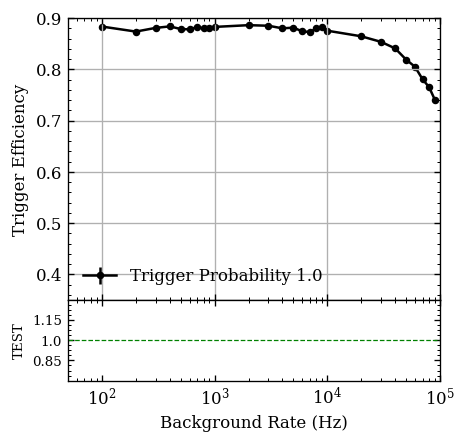

In [33]:
fig, [ax0, ax1] = modplot.axes(**ob)
# additional axis settings
ax0.set_xscale("log")
ax0.grid()
ax1.set_xscale("log")

for key in prob_dict.keys():

    # plot the distribution
    ax0.errorbar(prob_dict[key]['BkgRates'],prob_dict[key]['TrigEffs'],yerr=prob_dict[key]['TrigEff_errs'], **histStyle, label='Trigger Probability {}'.format(key))

ax1.plot(ob['xlim'], [1, 1], '--', color='green', lw=0.75)
# legend style and ordering
loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 1)
order = range(len(prob_dict.keys()))

# plot the legend
ax0.legend(**legend_opts)

fig.savefig('TrigEff_BkgRate_ProbTrig.pdf', bbox_inches='tight')
plt.show()

In [35]:
# Convert notebook into python file
!jupyter nbconvert --to python 'EfficiencyPlots.ipynb'

[NbConvertApp] Converting notebook EfficiencyPlots.ipynb to python
[NbConvertApp] Writing 7747 bytes to EfficiencyPlots.py
